# Imports

In [237]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import re
import time
from sklearn.impute import KNNImputer
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

start_time = time.time()


chunksize = 10 ** 3  # Chunksize de 1000 lignes
filename = 'products.csv'
nan_rates = []

try:
    reader = pd.read_csv(filename, chunksize=chunksize, sep='\t')

    for chunk in reader:
        nan_rates.append(chunk.isna().mean(axis=0))

except pd.errors.ParserError as e:
    print(f"ParserError: {e}")

# Calcul des taux moyens de remplissage des chunks
if nan_rates:
    inds_nan_rate = pd.concat(nan_rates, axis=1).mean(axis=1)
    cols_to_load = inds_nan_rate[inds_nan_rate < 0.7].index.tolist()

    # Chargement des données filtrées
    df = pd.read_csv(filename, sep='\t', usecols=cols_to_load)
    df = df.drop(['url','states','additives_n','nutrition-score-fr_100g','energy_100g','main_category','completeness','nutrient_levels_tags','brands','nova_group','food_groups','categories','creator','serving_size','serving_quantity','categories','image_nutrition_url','ingredients_analysis_tags','ingredients_tags','ingredients_text','image_nutrition_small_url','created_datetime','food_groups_tags','food_groups_en','states_tags','sodium_100g','states_en','last_image_datetime','last_modified_t','last_modified_datetime','created_t','last_modified_by','main_category_en','image_url','image_small_url','last_updated_t','last_image_t','brands_tags','last_updated_datetime','categories_en','categories_tags','countries_tags','countries_en'], axis=1)

# Remplacer les valeurs NaN par une chaîne vide pour éviter les erreurs de filtrage
df['countries'].fillna('', inplace=True)  

# Liste des mots clés à rechercher dans la colonne 'countries'
keywords = ['France', 'French', 'Francia', 'Frankreich', 'Polynésie française', 'FR', 'fr']

# Filtrer les lignes où 'countries' ne contient pas les mots clés spécifiés
mask = df['countries'].str.contains('|'.join(keywords), case=False, na=False)
df = df[mask]

ParserError: Error tokenizing data. C error: Expected 206 fields in line 1537879, saw 234



/var/folders/25/t6v1433n06x6vfl9wjbxn8sw0000gn/T/ipykernel_4411/615577520.py:36: DtypeWarning: Columns (0,50,52,56,58,88,89,91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, sep='\t', usecols=cols_to_load)


# Informations Dataframe

In [239]:
df.info

<bound method DataFrame.info of                          code                  product_name        countries  \
0           00000000000000225                jeunes pousses        en:france   
3        00000000000026772226                          Skyr           France   
4               0000000000017              Vitória crackers           France   
5               0000000000031                         Cacao           France   
11              0000000000100   moutarde au moût de raisin            France   
...                       ...                           ...              ...   
3307643              99999995                Steak haché 5%           France   
3307647         9999999905667                           NaN  en:South Africa   
3307649         9999999916298       Beurre de cacahuète bio            en:fr   
3307652             999999999       Thé noir BIO Darjeeling        en:france   
3307657         9999999999994     Light & Free SKYR A BOIRE        en:france   

       

In [240]:
df.head(5)

,code,product_name,countries,nutriscore_score,nutriscore_grade,pnns_groups_1,pnns_groups_2,ecoscore_grade,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,00000000000000225,jeunes pousses,en:france,NaN,unknown,Fruits and vegetables,Vegetables,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00000000000026772226,Skyr,France,-5.00,a,Milk and dairy products,Dairy desserts,b,57.00,0.20,0.10,3.90,3.90,NaN,10.00,0.09,NaN
4,0000000000017,Vitória crackers,France,NaN,unknown,unknown,unknown,unknown,375.00,7.00,3.08,70.10,15.00,NaN,7.80,1.40,NaN
5,0000000000031,Cacao,France,NaN,unknown,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0000000000100,moutarde au moût de raisin,France,18.00,d,Fat and sauces,Dressings and sauces,c,NaN,8.20,2.20,29.00,22.00,0.00,5.10,4.60,0.00


In [241]:
df.dtypes

code                                                      object
product_name                                              object
countries                                                 object
nutriscore_score                                          object
nutriscore_grade                                          object
pnns_groups_1                                             object
pnns_groups_2                                             object
ecoscore_grade                                            object
energy-kcal_100g                                          object
fat_100g                                                  object
saturated-fat_100g                                        object
carbohydrates_100g                                       float64
sugars_100g                                              float64
fiber_100g                                               float64
proteins_100g                                            float64
salt_100g                

In [242]:
df.isna().sum()

code                                                          0
product_name                                              35036
countries                                                     0
nutriscore_score                                         657501
nutriscore_grade                                           9708
pnns_groups_1                                              1044
pnns_groups_2                                              1042
ecoscore_grade                                             1240
energy-kcal_100g                                         278680
fat_100g                                                 262330
saturated-fat_100g                                       259299
carbohydrates_100g                                       262180
sugars_100g                                              259558
fiber_100g                                               797971
proteins_100g                                            260593
salt_100g                               

# Fonction Nettoyage Données

In [244]:
def clean_and_impute_data(df):
    
    def detect_and_remove_cyrillic(df, column):
        cyrillic_pattern = re.compile(r'[\u0400-\u04FF]+')
        mask = df[column].apply(lambda x: bool(cyrillic_pattern.search(str(x))))
        df.drop(df[mask].index, inplace=True)
        df.reset_index(drop=True, inplace=True)
        print(f"\nNombre de lignes supprimées : {mask.sum()}")
        print("Étape de suppression des caractères cyrilliques complétée.")
    
    def redistribute_nutrient_values(df, columns_to_check, max_sum=100):
        nutrient_sum = df[columns_to_check].sum(axis=1)
        mask = nutrient_sum > max_sum
        total = df.loc[mask, columns_to_check].sum(axis=1)
        factor = max_sum / total
        df.loc[mask, columns_to_check] *= factor.values[:, None]
    
    def check_nutrient_sum(df):
        columns_to_check = ['fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'carbohydrates_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']
        nutrient_sum = df[columns_to_check].sum(axis=1)
        mask = nutrient_sum > 100
        count_high_sum = mask.sum()
        if count_high_sum > 0:
            print(f"\nNombre de lignes avec une somme strictement supérieure à 100 : {count_high_sum}")
        else:
            print("Aucune ligne avec une somme des colonnes strictement supérieure à 100 trouvée.")
        
        return count_high_sum
    
    # Suppression cyrillique
    detect_and_remove_cyrillic(df, 'product_name')
    
    # Suppression des doublons basés sur le code
    df.drop_duplicates(subset='code', inplace=True)
    print("Étape de suppression des doublons basée sur le code complétée.")
    
    # Suppression des lignes avec des valeurs NaN dans 'product_name'
    df.dropna(subset=['product_name'], inplace=True)
    print(f"\nNombre de lignes supprimées avec NaN dans 'product_name': {df.shape[0] - df.dropna(subset=['product_name']).shape[0]}")
    print("Étape de suppression des lignes avec des NaN dans 'product_name' complétée.")
    
    # Remplacement des valeurs >100 par la moyenne en fonction du 'product_name'
    columns_to_check = [
        'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
        'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 
        'fruits-vegetables-nuts-estimate-from-ingredients_100g'
    ]
    
    df[columns_to_check] = df[columns_to_check].apply(pd.to_numeric, errors='coerce')
    means = df.groupby('product_name')[columns_to_check].transform('mean')
    
    df[columns_to_check] = np.where(df[columns_to_check] > 100, means, df[columns_to_check])
    
    values_above_100 = df[columns_to_check] > 100
    count_above_100 = values_above_100.sum().sum()
    print(f"Nombre de valeurs supérieures à 100 après correction : {count_above_100}")
    
    df.drop(df[values_above_100.any(axis=1)].index, inplace=True)
    print("Étape de remplacement des valeurs >100 par la moyenne complétée.")
    
    # Préparer les données pour l'imputation
    df[columns_to_check] = df[columns_to_check].applymap(lambda x: np.nan if x < 0 else x)
    
    # Imputation itérative des NaN
    imputer = IterativeImputer(max_iter=50, random_state=0, min_value=0, max_value=100)
    df_imputed = df.copy()
    df_imputed[columns_to_check] = imputer.fit_transform(df[columns_to_check])
    
    # Remplacer les valeurs imputées qui sont en dehors de l'intervalle 0-100
    df_imputed[columns_to_check] = df_imputed[columns_to_check].clip(0, 100)
    
    # Remplacer les colonnes imputées dans le DataFrame original
    df[columns_to_check] = df_imputed[columns_to_check]
    
    print("Étape d'imputation itérative des NaN et des valeurs négatives complétée.")
    
    # Suppression des lignes avec des valeurs négatives après imputation
    df = df[df[columns_to_check].ge(0).all(axis=1)]
    
    print("Étape de suppression des lignes avec des valeurs négatives complétée.")
    
    # Suppression des lignes où 'energy-kcal_100g' est supérieur à 900
    df['energy-kcal_100g'] = pd.to_numeric(df['energy-kcal_100g'], errors='coerce')
    df = df[df['energy-kcal_100g'] <= 900]
    print("Étape de suppression des lignes où 'energy-kcal_100g' est supérieur à 900 complétée.")
    
    # Redistribution des valeurs si la somme des colonnes dépasse 100
    modified_counter = check_nutrient_sum(df)
    print(f"\nNombre de valeurs modifiées pendant la redistribution : {modified_counter}")
    print("Étape de redistribution des valeurs complétée.")
    
    # Conversion de nutriscore_score en numérique
    df['nutriscore_score'] = pd.to_numeric(df['nutriscore_score'], errors='coerce')
    
    # Imputation des NaN dans 'nutriscore_score' par la médiane en fonction de 'product_name'
    df['nutriscore_score'] = df.groupby('product_name')['nutriscore_score'].transform(lambda x: x.fillna(x.median()))
    
    # Imputation itérative en utilisant d'autres colonnes pour guider l'imputation
    imputer = IterativeImputer(max_iter=100, random_state=10, min_value=0, max_value=900)
    columns_to_impute = ['energy-kcal_100g', 'fat_100g', 'sugars_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']
    df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])
    df = df.round(2)
    print("Étape de Iterative Imputer terminée")

    # Remplacer les valeurs "unknown" par NaN dans pnns_groups_1 et pnns_groups_2
    df['pnns_groups_1'].replace("unknown", np.nan, inplace=True)
    df['pnns_groups_2'].replace("unknown", np.nan, inplace=True)

    # Imputation des NaN dans 'pnns_groups_2' par la modalité la plus fréquente en fonction de 'product_name'
    df['pnns_groups_2'] = df.groupby('product_name')['pnns_groups_2'].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
    )

    return df

# Exécuter la fonction sur votre DataFrame
df = clean_and_impute_data(df)



Nombre de lignes supprimées : 424
Étape de suppression des caractères cyrilliques complétée.
Étape de suppression des doublons basée sur le code complétée.

Nombre de lignes supprimées avec NaN dans 'product_name': 0
Étape de suppression des lignes avec des NaN dans 'product_name' complétée.
Nombre de valeurs supérieures à 100 après correction : 1290
Étape de remplacement des valeurs >100 par la moyenne complétée.


/var/folders/25/t6v1433n06x6vfl9wjbxn8sw0000gn/T/ipykernel_4411/4076232009.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns_to_check] = df[columns_to_check].applymap(lambda x: np.nan if x < 0 else x)


Étape d'imputation itérative des NaN et des valeurs négatives complétée.
Étape de suppression des lignes avec des valeurs négatives complétée.
Étape de suppression des lignes où 'energy-kcal_100g' est supérieur à 900 complétée.

Nombre de lignes avec une somme strictement supérieure à 100 : 271585

Nombre de valeurs modifiées pendant la redistribution : 271585
Étape de redistribution des valeurs complétée.
Étape de Iterative Imputer terminée


# Visualisations

## Matrices de corrélation

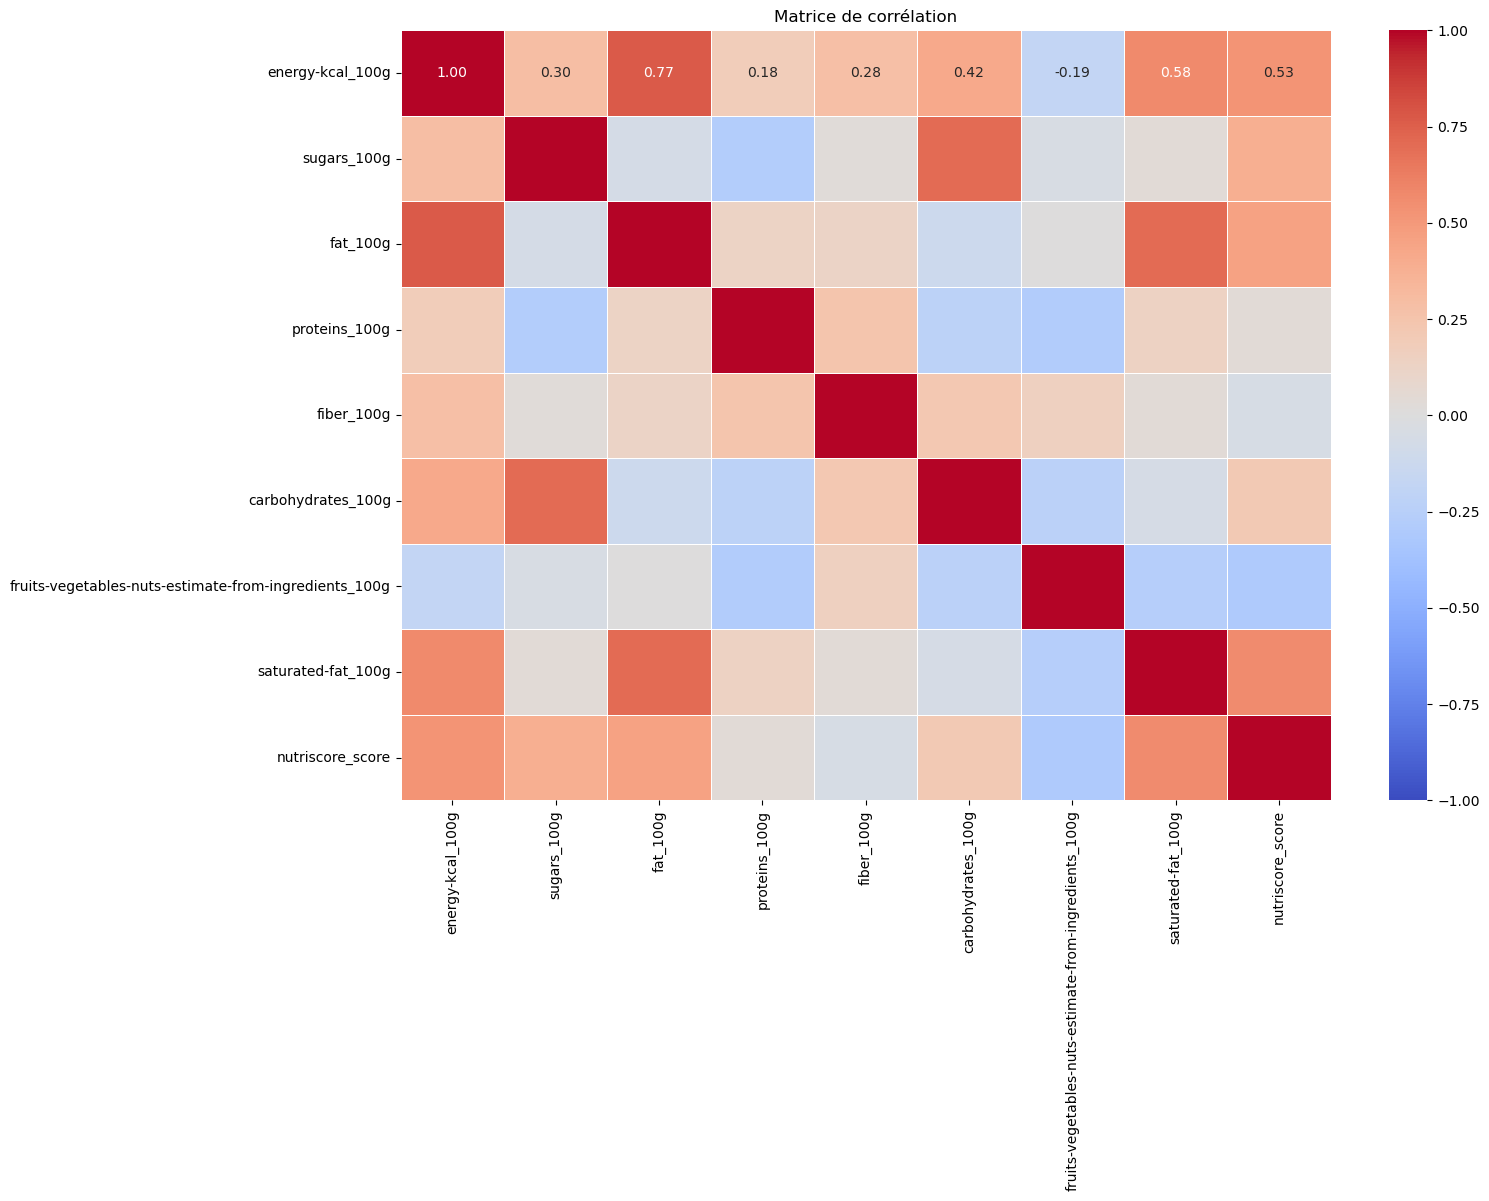

In [247]:
correlation_matrix = df[['energy-kcal_100g', 'sugars_100g', 'fat_100g', 'proteins_100g', 'fiber_100g', 'carbohydrates_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'saturated-fat_100g', 'nutriscore_score']].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=.5, fmt=".2f", annot_kws={"size": 10})
plt.title('Matrice de corrélation')
plt.show()

## Graphes

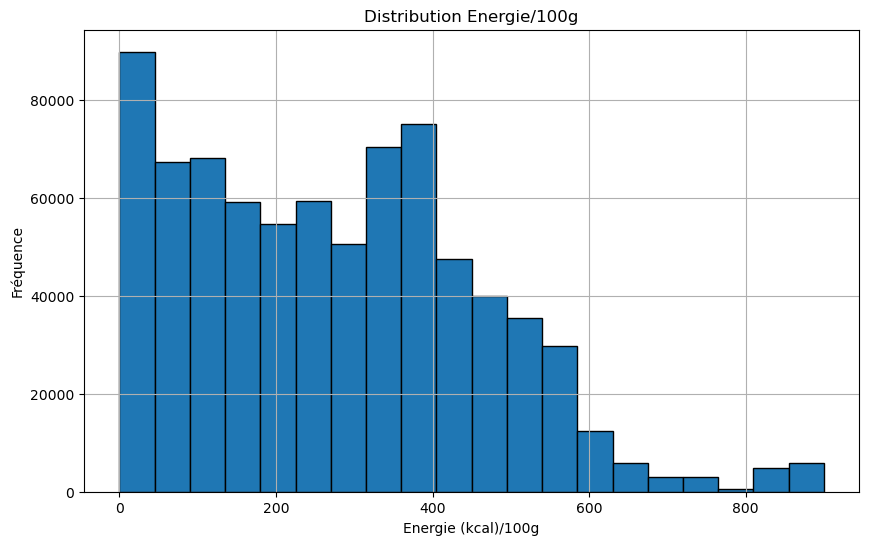

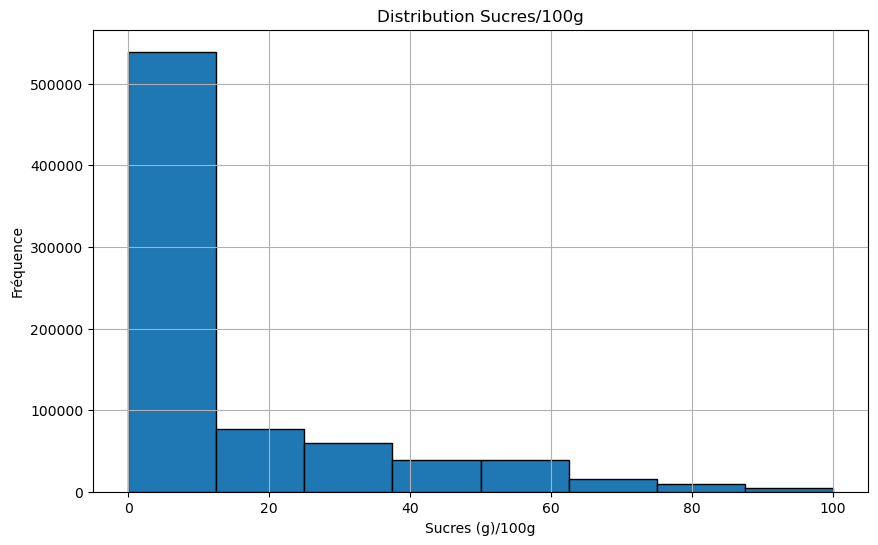

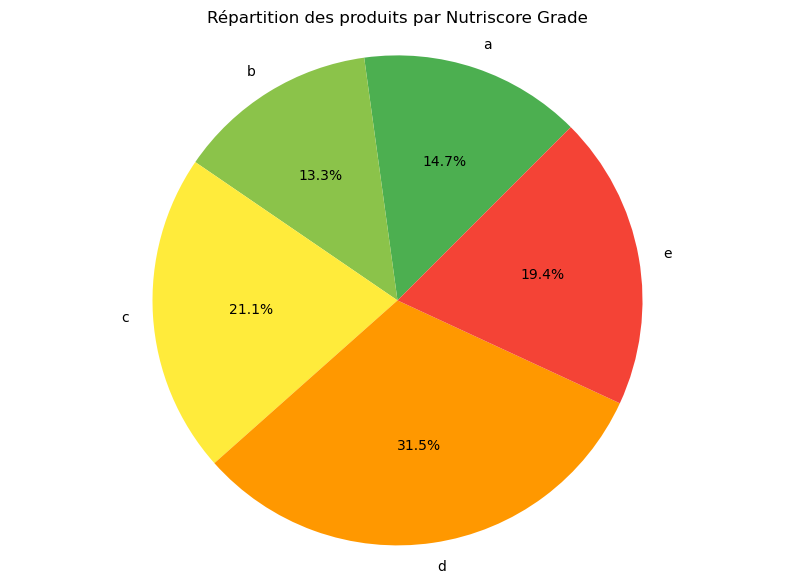

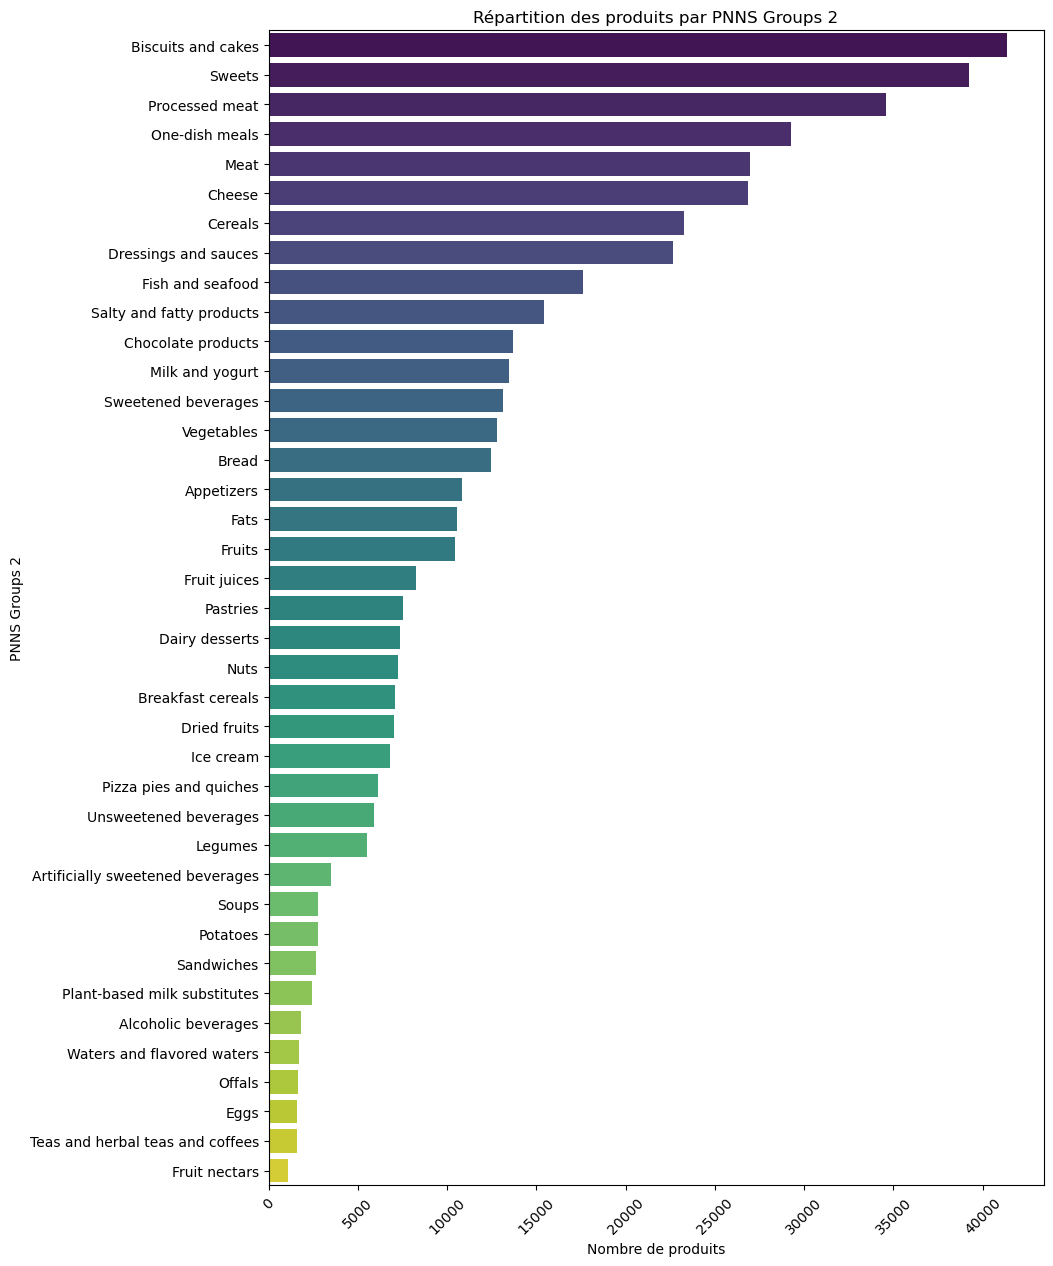

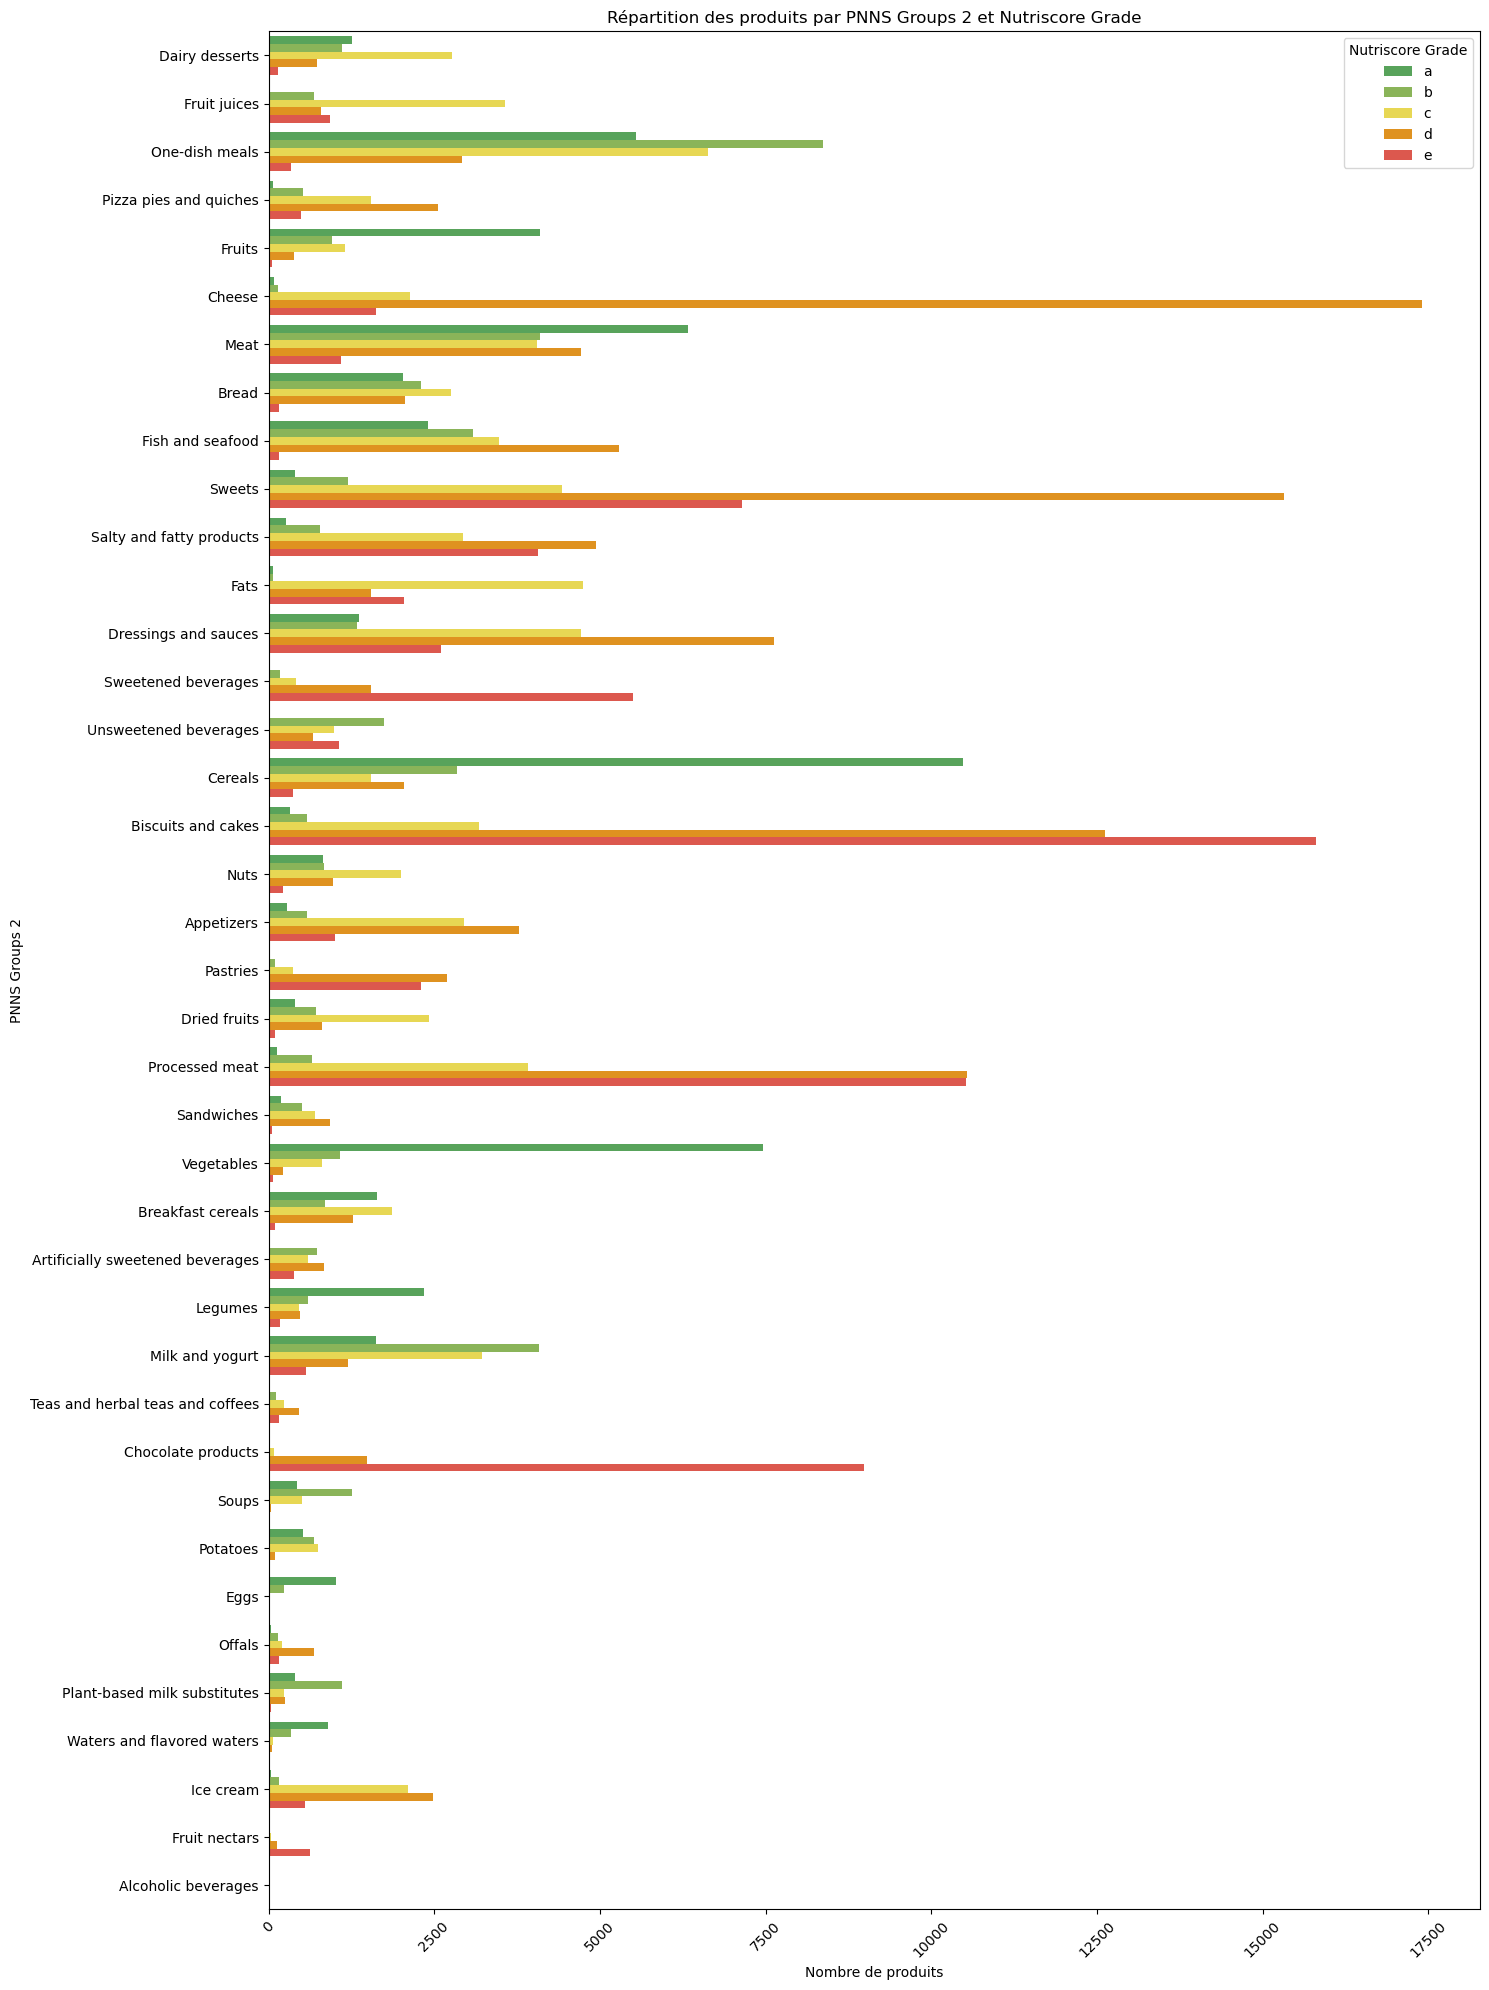

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

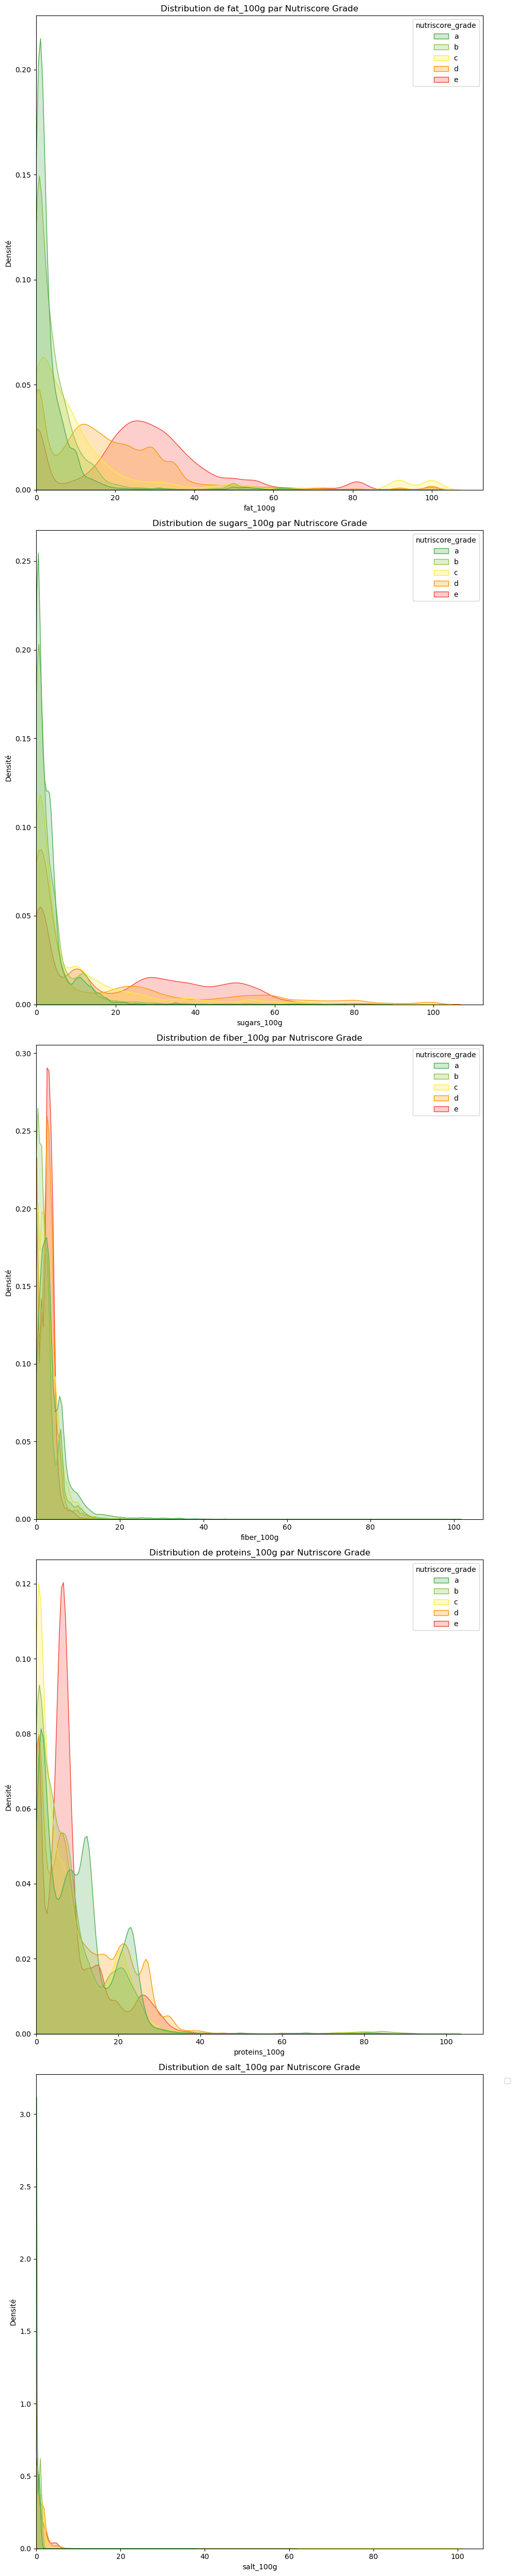

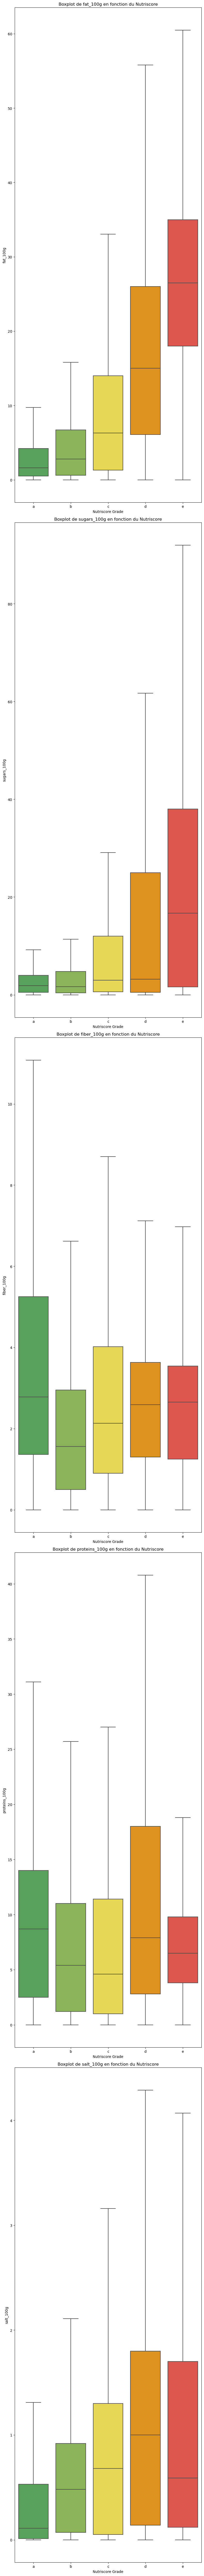

In [249]:
# Définir les variables à analyser
variables = ['fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g']

# Définir la palette de couleurs pour les grades Nutri-Score
palette_colors = {
    'a': '#4CAF50',  # Vert foncé
    'b': '#8BC34A',  # Vert clair
    'c': '#FFEB3B',  # Jaune
    'd': '#FF9800',  # Orange
    'e': '#F44336'   # Rouge
}

# La fonction generate_plots définie précédemment
def generate_plots(df, variables, palette_colors):
    """
    Génère différents types de graphiques pour les données fournies dans l'ordre spécifié.
    
    Parameters:
    - df: DataFrame contenant les données.
    - variables: Liste des variables à analyser pour les boxplots et les courbes de densité.
    - palette_colors: Dictionnaire définissant les couleurs pour chaque grade Nutri-Score.
    
    Returns:
    - None
    """
    
    # Remplacer les valeurs infinies par NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Filtrer les grades pour exclure "unknown" et "not-applicable"
    df_filtre = df[~df['nutriscore_grade'].isin(['unknown', 'not-applicable'])]

    # Obtenir les grades Nutri-Score uniques, les convertir en chaînes, et les trier en ordre alphabétique
    grades_ordonnes = sorted(df_filtre['nutriscore_grade'].dropna().astype(str).unique())

    # Créer une palette adaptée aux grades présents dans les données
    palette = {grade: palette_colors.get(grade, '#C0C0C0') for grade in grades_ordonnes}

    # --- 1. Histogrammes ---
    # Histogramme pour 'energy-kcal_100g'
    plt.figure(figsize=(10, 6))
    plt.hist(df['energy-kcal_100g'].dropna(), edgecolor='black', bins=20)
    plt.xlabel('Energie (kcal)/100g')
    plt.ylabel('Fréquence')
    plt.title('Distribution Energie/100g')
    plt.grid(True)
    plt.show()

    # Histogramme pour 'sugars_100g'
    plt.figure(figsize=(10, 6))
    plt.hist(df['sugars_100g'].dropna(), edgecolor='black', bins=8)
    plt.xlabel('Sucres (g)/100g')
    plt.ylabel('Fréquence')
    plt.title('Distribution Sucres/100g')
    plt.grid(True)
    plt.show()

    # --- 2. Camembert ---
    # Obtenir les comptes des grades Nutri-Score
    score_counts = df_filtre['nutriscore_grade'].value_counts()

    # Trier les counts en fonction de l'ordre alphabétique des grades
    score_counts_ordonnes = score_counts[grades_ordonnes]

    # Créer une liste de couleurs correspondant aux grades présents dans les données
    colors = [palette.get(grade, '#C0C0C0') for grade in grades_ordonnes]

    plt.figure(figsize=(10, 7))
    plt.pie(score_counts_ordonnes, labels=grades_ordonnes, autopct='%1.1f%%', startangle=45, colors=colors)
    plt.title('Répartition des produits par Nutriscore Grade')
    plt.axis('equal')  # Assure que le camembert est un cercle
    plt.show()

    # --- 3. Countplot général ---
    comptages = df['pnns_groups_2'].value_counts()
    plt.figure(figsize=(10, 15))
    sns.countplot(data=df, y='pnns_groups_2', order=comptages.index, palette='viridis')
    plt.title('Répartition des produits par PNNS Groups 2')
    plt.ylabel('PNNS Groups 2')
    plt.xlabel('Nombre de produits')
    plt.xticks(rotation=45)
    plt.show()
    
    # --- 4. Countplot filtré avec Nutriscore Grade ---
    comptages = df_filtre['pnns_groups_2'].value_counts()
    plt.figure(figsize=(15, 20))
    sns.countplot(y='pnns_groups_2', hue='nutriscore_grade', data=df_filtre, palette=palette, hue_order=grades_ordonnes)
    plt.title('Répartition des produits par PNNS Groups 2 et Nutriscore Grade')
    plt.xlabel('Nombre de produits')
    plt.ylabel('PNNS Groups 2')
    plt.xticks(rotation=45)
    plt.legend(title='Nutriscore Grade')
    plt.tight_layout()
    plt.show()

    # --- 5. Courbes de Densité (KDE) ---
    plt.figure(figsize=(10, 50))  # Ajuster la taille de la figure (largeur, hauteur)
    for i, var in enumerate(variables, start=1):
        plt.subplot(len(variables), 1, i)  # Ajuster le nombre de lignes dynamiquement
        sns.kdeplot(data=df_filtre, x=var, hue='nutriscore_grade', fill=True, common_norm=False, hue_order=grades_ordonnes, palette=palette)
        plt.title(f'Distribution de {var} par Nutriscore Grade')
        plt.xlabel(var)
        plt.ylabel('Densité')
        plt.xlim(left=0)  # Forcer le début de l'axe x à 0
    plt.subplots_adjust(right=0.8, hspace=0.5)  # Ajustement horizontal et espace vertical
    plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # --- 6. Boxplots ---
    plt.figure(figsize=(8, 100))  # Ajuster la taille de la figure (largeur, hauteur)
    for i, var in enumerate(variables, start=1):
        plt.subplot(len(variables), 1, i)  # Ajuster le nombre de lignes dynamiquement
        sns.boxplot(x='nutriscore_grade', y=var, data=df_filtre, palette=palette, order=grades_ordonnes, showfliers=False)
        plt.title(f'Boxplot de {var} en fonction du Nutriscore')
        plt.xlabel('Nutriscore Grade')
        plt.ylabel(var)
    plt.tight_layout()
    plt.show()

# Appel de la fonction avec les données définies
generate_plots(df, variables, palette_colors)


## Zoom sur categories fruits / legumes

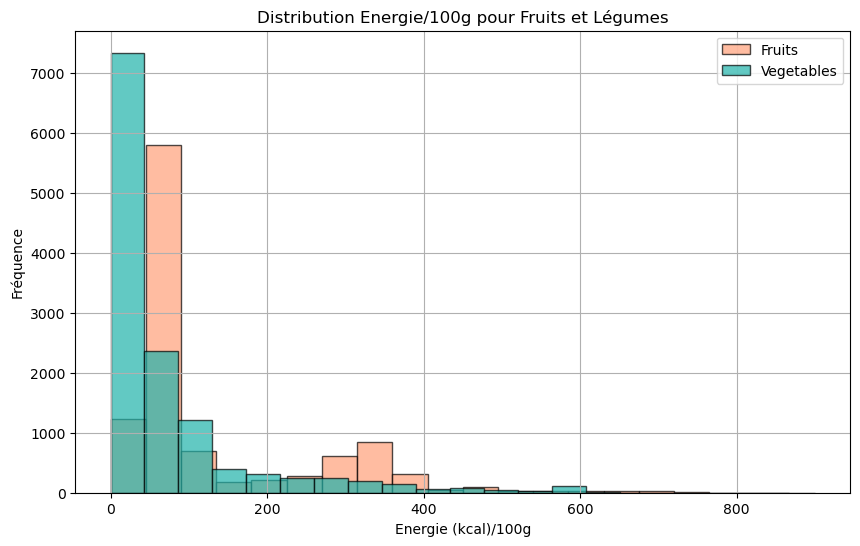

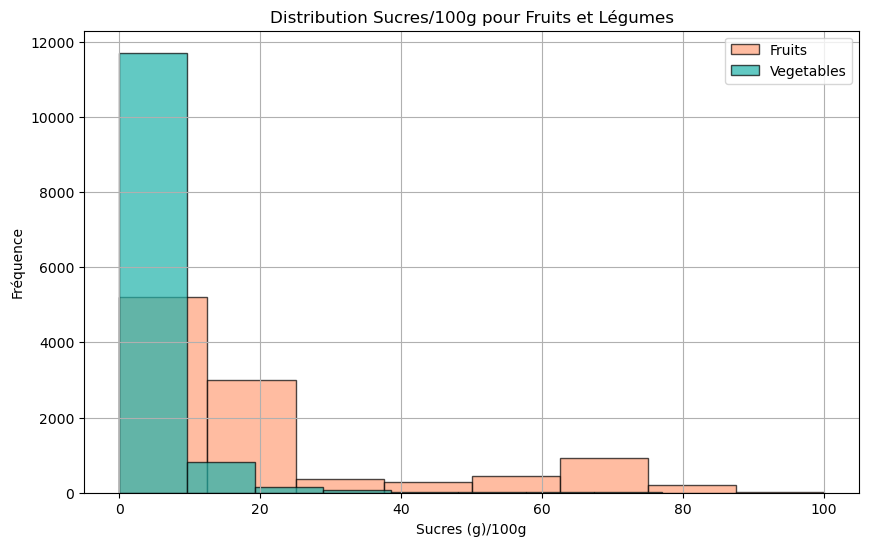

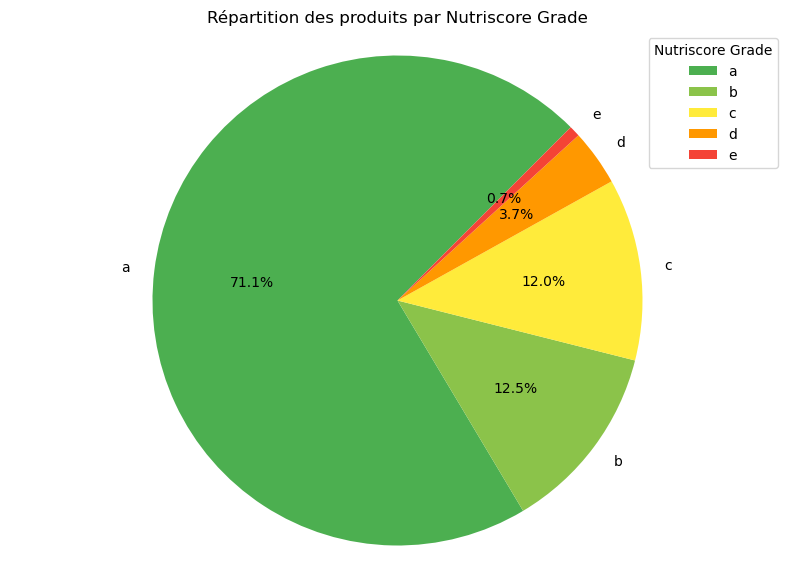

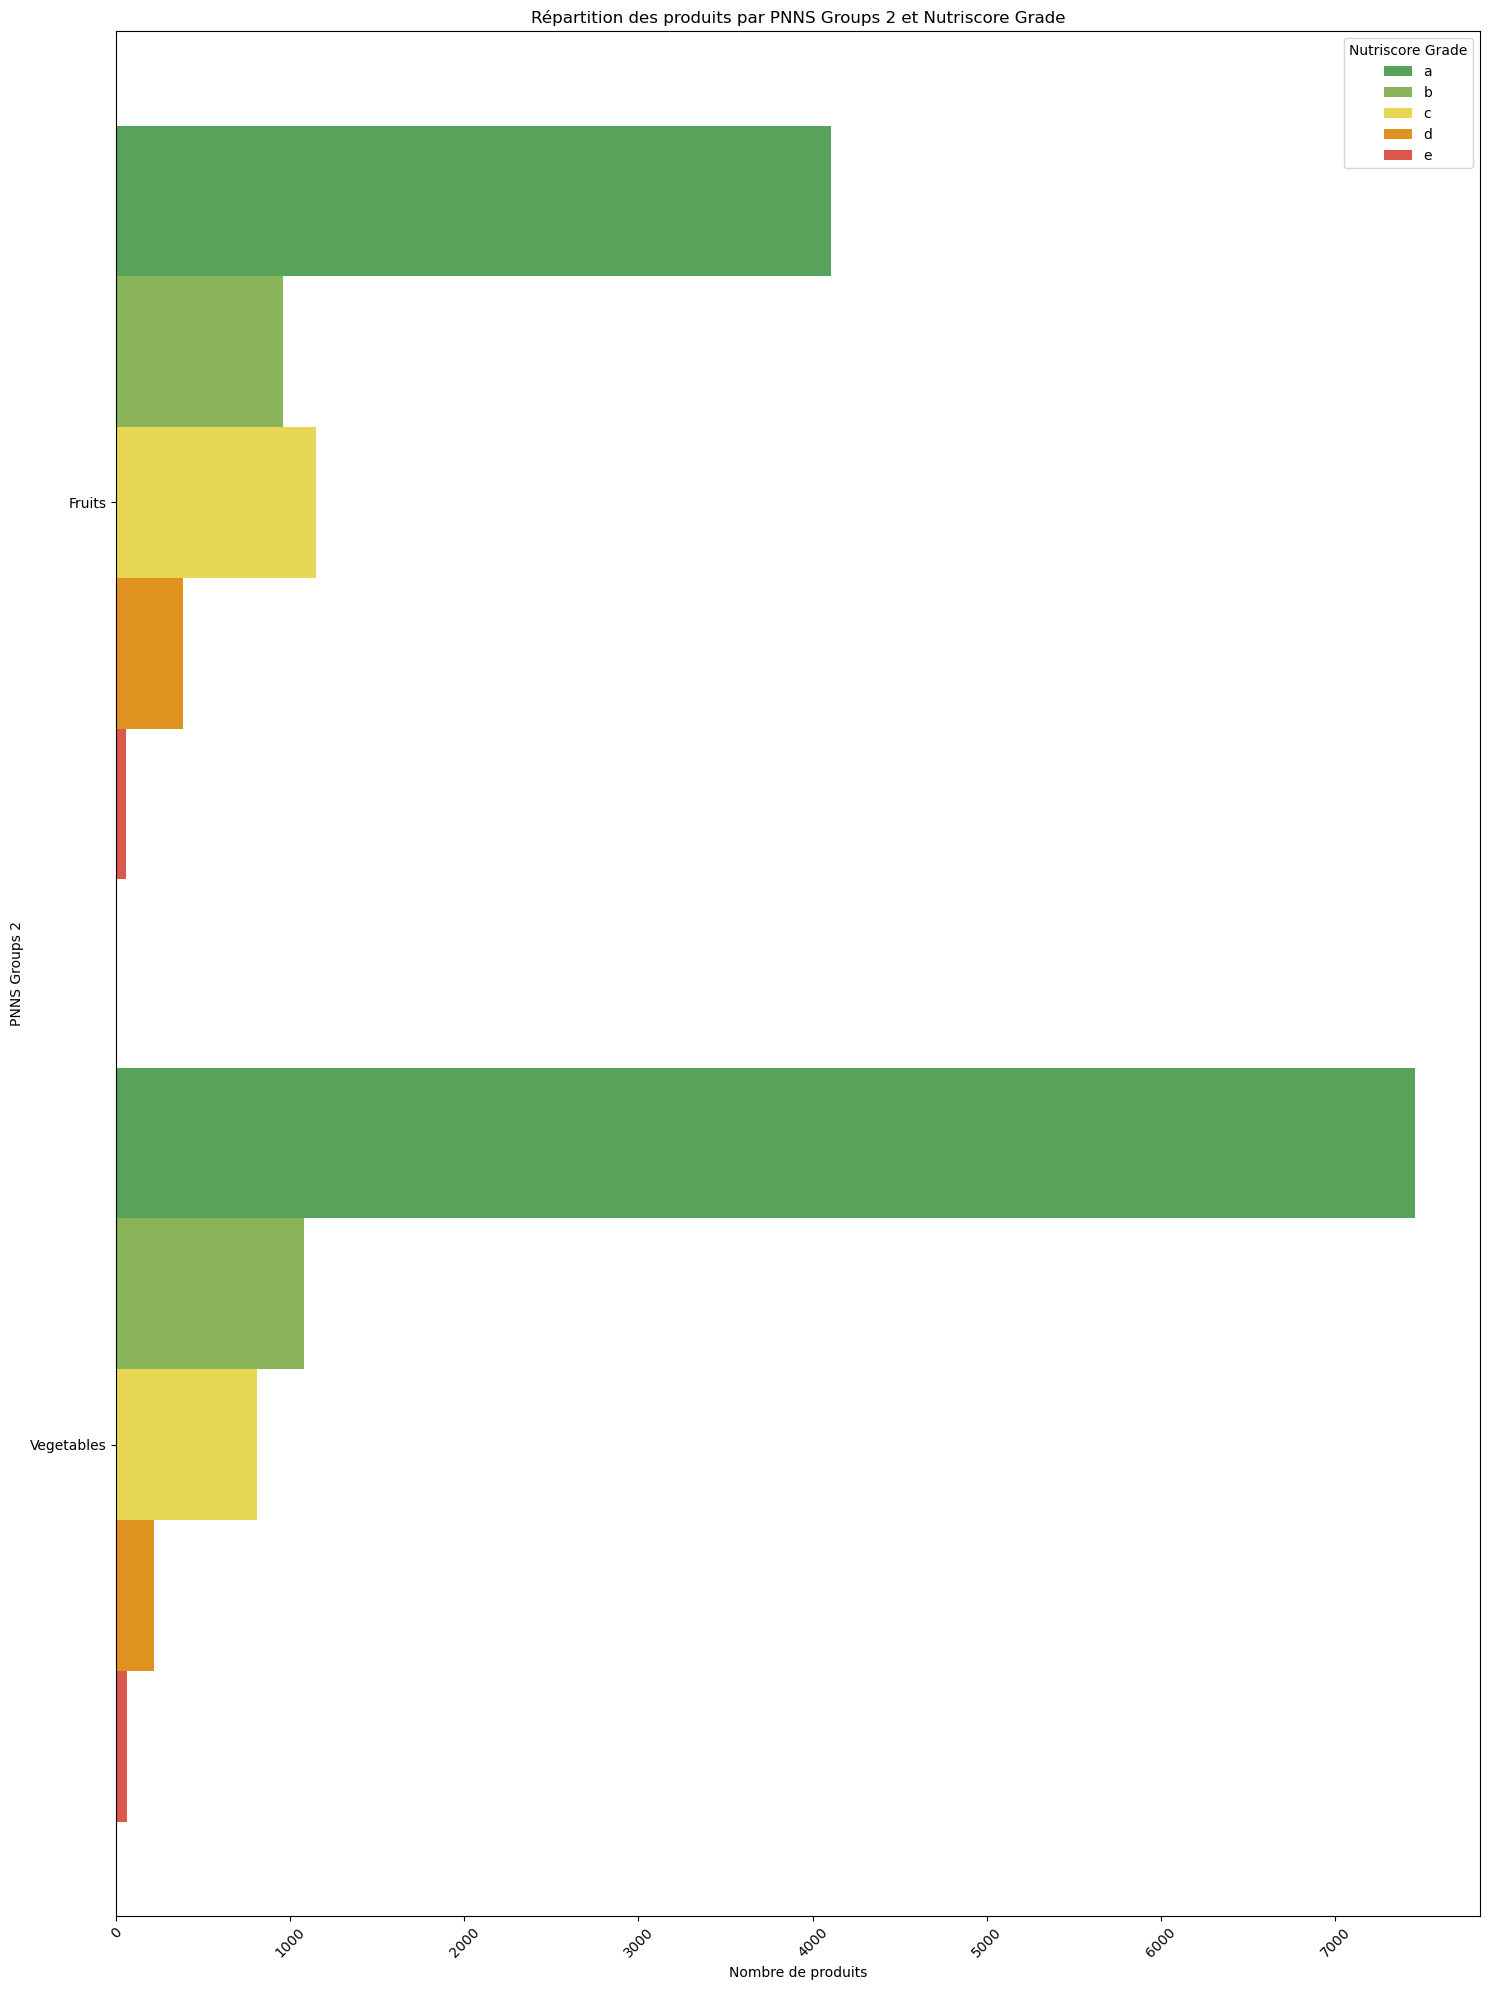

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

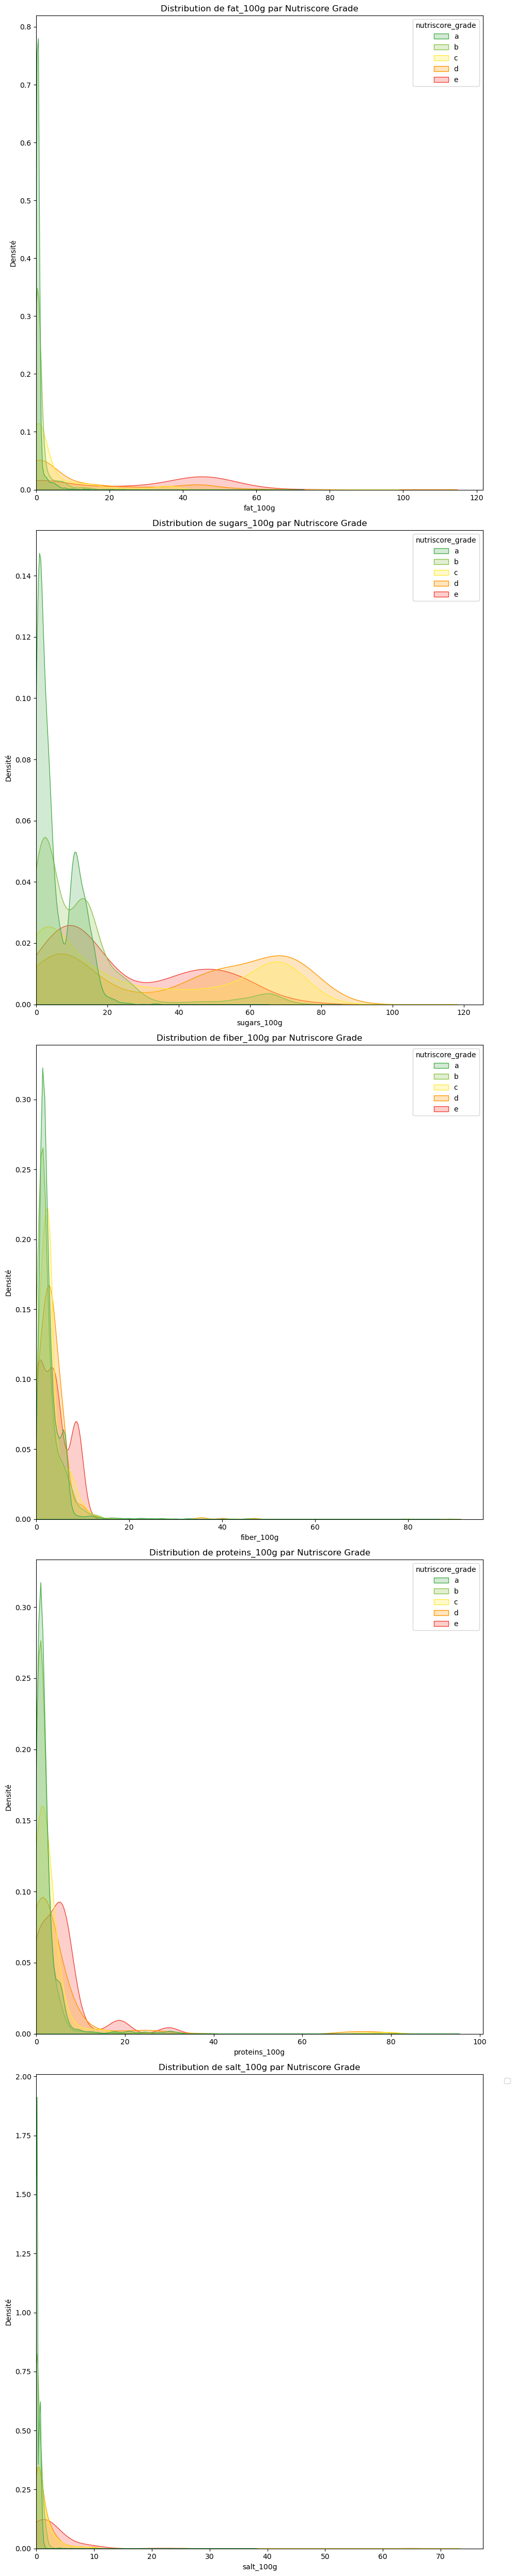

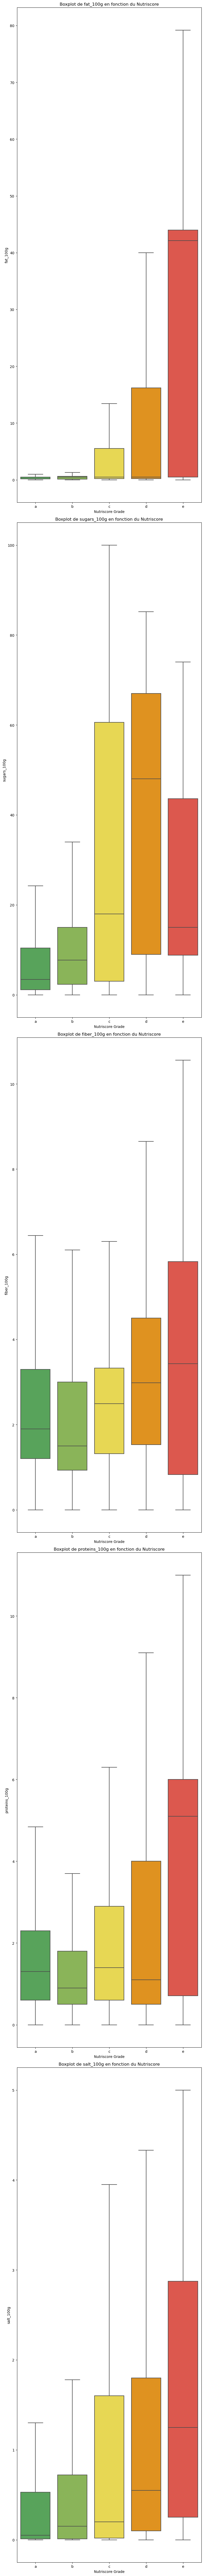

In [251]:
# Définir les variables à analyser
variables = ['fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g']

# Définir la palette de couleurs pour les grades Nutri-Score
palette_colors = {
    'a': '#4CAF50',  # Vert foncé
    'b': '#8BC34A',  # Vert clair
    'c': '#FFEB3B',  # Jaune
    'd': '#FF9800',  # Orange
    'e': '#F44336'   # Rouge
}

# La fonction generate_plots définie précédemment
def generate_plots(df, variables, palette_colors):
    """
    Génère différents types de graphiques pour les données fournies dans l'ordre spécifié.
    
    Parameters:
    - df: DataFrame contenant les données.
    - variables: Liste des variables à analyser pour les boxplots et les courbes de densité.
    - palette_colors: Dictionnaire définissant les couleurs pour chaque grade Nutri-Score.
    
    Returns:
    - None
    """
    
    # Remplacer les valeurs infinies par NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Filtrer les données pour ne conserver que les 'Fruits' et 'Vegetables'
    df = df[df['pnns_groups_2'].isin(['Fruits', 'Vegetables'])]

    # Filtrer les grades pour exclure "unknown" et "not-applicable"
    df_filtre = df[~df['nutriscore_grade'].isin(['unknown', 'not-applicable'])]

    # Obtenir les grades Nutri-Score uniques, les convertir en chaînes, et les trier en ordre alphabétique
    grades_ordonnes = sorted(df_filtre['nutriscore_grade'].dropna().astype(str).unique())

    # Créer une palette adaptée aux grades présents dans les données
    palette = {grade: palette_colors.get(grade, '#C0C0C0') for grade in grades_ordonnes}

    # --- 1. Histogrammes combinés pour Fruits et Vegetables ---
    categories = ['Fruits', 'Vegetables']
    colors = ['#FFA07A', '#20B2AA']  # Couleurs différentes pour les catégories

    plt.figure(figsize=(10, 6))
    for category, color in zip(categories, colors):
        df_category = df[df['pnns_groups_2'] == category]
        plt.hist(df_category['energy-kcal_100g'].dropna(), edgecolor='black', bins=20, alpha=0.7, label=category, color=color)
    plt.xlabel('Energie (kcal)/100g')
    plt.ylabel('Fréquence')
    plt.title('Distribution Energie/100g pour Fruits et Légumes')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    for category, color in zip(categories, colors):
        df_category = df[df['pnns_groups_2'] == category]
        plt.hist(df_category['sugars_100g'].dropna(), edgecolor='black', bins=8, alpha=0.7, label=category, color=color)
    plt.xlabel('Sucres (g)/100g')
    plt.ylabel('Fréquence')
    plt.title('Distribution Sucres/100g pour Fruits et Légumes')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 2. Camembert ---
    # Obtenir les comptes des grades Nutri-Score
    score_counts = df_filtre['nutriscore_grade'].value_counts()

    # Trier les counts en fonction de l'ordre alphabétique des grades
    score_counts_ordonnes = score_counts[grades_ordonnes]

    # Créer une liste de couleurs correspondant aux grades présents dans les données
    colors = [palette.get(grade, '#C0C0C0') for grade in grades_ordonnes]

    plt.figure(figsize=(10, 7))
    plt.pie(score_counts_ordonnes, labels=grades_ordonnes, autopct='%1.1f%%', startangle=45, colors=colors)
    plt.title('Répartition des produits par Nutriscore Grade')
    plt.axis('equal')  # Assure que le camembert est un cercle
    plt.legend(title='Nutriscore Grade')
    plt.show()

    
    # --- 4. Countplot filtré avec Nutriscore Grade ---
    comptages = df_filtre['pnns_groups_2'].value_counts()
    plt.figure(figsize=(15, 20))
    sns.countplot(y='pnns_groups_2', hue='nutriscore_grade', data=df_filtre, palette=palette, hue_order=grades_ordonnes)
    plt.title('Répartition des produits par PNNS Groups 2 et Nutriscore Grade')
    plt.xlabel('Nombre de produits')
    plt.ylabel('PNNS Groups 2')
    plt.xticks(rotation=45)
    plt.legend(title='Nutriscore Grade')
    plt.tight_layout()
    plt.show()

    # --- 5. Courbes de Densité (KDE) ---
    plt.figure(figsize=(10, 50))  # Ajuster la taille de la figure (largeur, hauteur)
    for i, var in enumerate(variables, start=1):
        plt.subplot(len(variables), 1, i)  # Ajuster le nombre de lignes dynamiquement
        sns.kdeplot(data=df_filtre, x=var, hue='nutriscore_grade', fill=True, common_norm=False, hue_order=grades_ordonnes, palette=palette)
        plt.title(f'Distribution de {var} par Nutriscore Grade')
        plt.xlabel(var)
        plt.ylabel('Densité')
        plt.xlim(left=0)  # Forcer le début de l'axe x à 0
    plt.subplots_adjust(right=0.8, hspace=0.5)  # Ajustement horizontal et espace vertical
    plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # --- 6. Boxplots ---
    plt.figure(figsize=(8, 100))  # Ajuster la taille de la figure (largeur, hauteur)
    for i, var in enumerate(variables, start=1):
        plt.subplot(len(variables), 1, i)  # Ajuster le nombre de lignes dynamiquement
        sns.boxplot(x='nutriscore_grade', y=var, data=df_filtre, palette=palette, order=grades_ordonnes, showfliers=False)
        plt.title(f'Boxplot de {var} en fonction du Nutriscore')
        plt.xlabel('Nutriscore Grade')
        plt.ylabel(var)
    plt.tight_layout()
    plt.show()

# Appel de la fonction avec les données définies
generate_plots(df, variables, palette_colors)

# Test de kruskal wallis

In [ ]:
data_columns = ['energy-kcal_100g', 'sugars_100g', 'fat_100g', 'proteins_100g', 'fiber_100g', 'carbohydrates_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'saturated-fat_100g', 'nutriscore_score']

results = []
rejected_count = 0
not_rejected_count = 0

# Comparer chaque paire de colonnes
for i in range(len(data_columns)):
    for j in range(i + 1, len(data_columns)):
        col1 = data_columns[i]
        col2 = data_columns[j]
        data1 = df[col1].dropna()
        data2 = df[col2].dropna()
        
        # Effectuer le test de Kruskal-Wallis
        stat, p_value = stats.kruskal(data1, data2)
        alpha = 0.02
        if p_value < alpha:
            rejected_count += 1
        else:
            not_rejected_count += 1
        
print(f"\nHypothèses rejetées : {rejected_count}")
print(f"Hypothèses non rejetées : {not_rejected_count}")

# ACP

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Définir les colonnes à analyser
data_columns = ['sugars_100g', 'fat_100g', 'proteins_100g', 'fiber_100g', 'carbohydrates_100g']

# Charger les données (assurez-vous que 'data' et 'df' sont bien définis)
# data = ...  # DataFrame contenant les colonnes à analyser
# df = ...    # DataFrame contenant toutes les données, y compris 'pnns_groups_2'

# Standardiser les données
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[data_columns])

# Calculer l'ACP
pca = PCA(n_components=len(data_columns))
pca.fit(data_scaled)

# Obtenir les composantes principales et les valeurs expliquées
components = pca.components_
explained_variance = pca.explained_variance_ratio_

# Ébouli des valeurs propres
eigenvalues = pca.explained_variance_
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.title('Ébouli des valeurs propres')
plt.xlabel('Numéro de la composante principale')
plt.ylabel('Valeur propre')
plt.grid(True)
plt.show()

# Afficher la proportion de variance expliquée par chaque composant principal
print("Proportion de variance expliquée par chaque composant principal:")
for i, var in enumerate(explained_variance, start=1):
    print(f"Composant Principal {i}: {var:.4f}")

# Créer un DataFrame des résultats de l'ACP
pca_results = pd.DataFrame(data=pca.transform(data_scaled), columns=[f'PC{i+1}' for i in range(len(data_columns))])
pca_results['pnns_groups_2'] = df['pnns_groups_2']  # Assurez-vous que cette colonne existe

# Visualiser la variance expliquée cumulée
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o')
plt.xlabel('Nombre de Composants Principaux')
plt.ylabel('Variance Cumulée Expliquée')
plt.title('Variance Cumulée Expliquée par les Composants Principaux')
plt.grid(True)
plt.show()

# Visualiser les premières composantes principales
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_results['PC1'], y=pca_results['PC2'])
plt.xlabel('Composant Principal 1')
plt.ylabel('Composant Principal 2')
plt.title('Projection des Données sur les 2 Premiers Composants Principaux')
plt.grid(True)
plt.show()

# Visualiser les charges des variables sur le premier composant principal
plt.figure(figsize=(10, 6))
plt.bar(range(len(data_columns)), pca.components_[0])
plt.xlabel('Variables')
plt.ylabel('Charge sur le Composant Principal 1')
plt.title('Charges des Variables sur le Composant Principal 1')
plt.xticks(ticks=range(len(data_columns)), labels=data_columns, rotation=45)
plt.grid(True)
plt.show()

# Cercle des Corrélations
plt.figure(figsize=(10, 10))
circle = plt.Circle((0, 0), 1, color='b', fill=False, linestyle='--')
plt.gca().add_artist(circle)
for i, var in enumerate(data_columns):
    plt.quiver(0, 0, pca.components_[0, i], pca.components_[1, i], angles='xy', scale_units='xy', scale=1, color='r')
    plt.text(pca.components_[0, i]*1.1, pca.components_[1, i]*1.1, var, color='r', ha='center', fontsize=12)
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.xlabel('Composant Principal 1')
plt.ylabel('Composant Principal 2')
plt.title('Cercle des Corrélations')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Projection des points sur F1 et F2 avec coloration par PNNS Groups 2
plt.figure(figsize=(15, 30))
scatter = sns.scatterplot(x='PC1', y='PC2', hue='pnns_groups_2', data=pca_results)
plt.xlabel('Composant Principal 1 (F1)')
plt.ylabel('Composant Principal 2 (F2)')
plt.title('Projection sur F1 et F2 avec Coloration par PNNS Groups 2')

# Déplacer la légende en dehors du graphe
plt.legend(title='PNNS Groups 2', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


# Timer

In [ ]:
end_time = time.time()
execution_time = end_time - start_time

print(f"Temps d'exécution total du notebook : {execution_time:.4f} secondes")

In [ ]:
zero_percentages = (df == 0).sum() / df.shape[0] * 100
nan_percentages = df.isna().sum() / df.shape[0] * 100
print("Pourcentage des valeurs égales à 0 :")
print(zero_percentages)
print("\nPourcentage des NaN :")
print(nan_percentages)

In [ ]:
df.isna().sum()

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)
print(df.describe())

In [ ]:
df.head(10)